In [1]:
%matplotlib inline
import os 
import sys
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, spearmanr,pearsonr, fisher_exact,kstest
from scipy.stats import ks_2samp, kstest, anderson, anderson_ksamp, levene
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from sklearn import preprocessing
import statsmodels.api as sm
pd.options.display.max_columns = 999
import statsmodels.formula.api as smf
import scipy.stats as ss 
import math 
from outliers import smirnov_grubbs as grubbs

plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

datadir       = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM/Oct_19'
mrsdir        = '/Users/kanaan/SCR/Dataframes_20150820/REVISION_DF'
clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
save_fig_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python'

measures = ['Puta', 'Caud', 'Thal',
            'SN', 'STN', 'RN',  'GPi' , 'GPe',  
            #'DN','Hipp', 'Accu', 'Amyg', 
            #'STR_cMOT', 'STR_rMOT','AAN_PPN','AAN_VTA',
            'BrainStem', 'BasalGanglia'
            ]

drop_c = ['WSKT','SC1T','LL5T', 'GSAT'] 
# WSKT,SC1T,LL5T Young Females scanned extra for MRS review. 
# GSAT removed since HSPP female removed 
drop_p = ['AA8P', 'RA9P', 'STDP','NL2P','HSPP', 'DF2P'] 
# AA8P motion outliers via mehalonobis distance for Quality metrics 
# rest – mehalonobis distance for SN,STN,Puta


In [2]:

def get_all_dfs(img, population, study_id, trt=False):
    quant = 'median'
    QSM = pd.read_csv(os.path.join(datadir, '%s_%s_%s_%s.csv'%(img, quant, population, study_id)),index_col = 0)
    QSM['Gender']  = QSM['Gender'].map({' F': 1, ' M': 0})
    
    CLN = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s_a.csv'%(population)), index_col=0)
    CLN.columns = ['CLN_' + str(col) for col in CLN.columns]    

    def get_mrs(vox):
        if trt == False:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_%s.csv'%(vox, population, study_id)),index_col = 0)
            #print df.head()
        elif trt == True:
            df = pd.read_csv(os.path.join(mrsdir, 'moco_df_%s_%s_trt_%s.csv'%(vox, population, study_id)),index_col = 0)
            df.index = [i[0:4] for i in df.index]
            #print df.head()
        df.columns = ['%s_'%vox + str(col) for col in df.columns]
        return df
    df = pd.concat([QSM, get_mrs('STR'), CLN], axis=1, join_axes=[QSM.index])
    df['L_BrainStem']    = (df['L_STN'] + df['L_SN'] +  df['L_RN']) / 3
    df['R_BrainStem']    = (df['R_STN'] + df['R_SN'] +  df['R_RN']) / 3
    df['L_BasalGanglia'] = (df['L_Puta'] + df['L_Caud'] +  df['L_Pall']) / 3
    df['R_BasalGanglia'] = (df['R_Puta'] + df['R_Caud'] +  df['R_Pall']) / 3
    df['L_ALL_NUCLEI'] = (df['L_BrainStem'] + df['L_BasalGanglia']) / 2
    df['R_ALL_NUCLEI'] = (df['R_BrainStem'] + df['R_BasalGanglia']) / 2
    df['ALL_NUCLEI'] = (df['BrainStem'] + df['BasalGanglia']) / 2
    return df

controls_a = get_all_dfs('QSM', 'controls', 'a').drop(drop_c, axis = 0) 
patients_a = get_all_dfs('QSM', 'patients', 'a').drop(drop_p, axis = 0)
controls_b = get_all_dfs('QSM', 'controls', 'b', trt=True)#.drop(drop_c, axis = 0) 
patients_b = get_all_dfs('QSM', 'patients', 'b', trt=True)#.drop(drop_p, axis = 0) 

controls_a['Population'] = 0
patients_a['Population'] = 1
    
controls_b.index = controls_b.index + 'b'
patients_b.index = patients_b.index + 'b'

DF_ALL =pd.concat([controls_a, patients_a], axis=0)

In [3]:
print np.mean(patients_a.L_BasalGanglia) * 1000


24.6173939394


In [4]:
def grubbs_outliers(df, measure, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df[measure], alpha).index] 
def grubbs_outliersx(df, alpha = 0.15):
    from outliers import smirnov_grubbs as grubbs
    return [str(i) for i in df.index if i not in grubbs.test(df, alpha).index] 

def gESD_outliers(df, measure, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df[measure],maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 


def gESD_outliersx(df, maxOLs =10, alpha = 0.05):
    from PyAstronomy import pyasl
    index = pyasl.generalizedESD(df,maxOLs = maxOLs, alpha =alpha, fullOutput=True)[1]
    return [df.index[i] for i in index] 

def plot_partial_correlation(data, x, y,xlim = None, ylim = None, regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
                             plot_marg = 1, ci = 95, lstyle='-',lw=2.5):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, x_partial = df[regressors], y_jitter = jitter, 
                    ci = ci, line_kws={'linestyle': lstyle, 'lw':lw})
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)
    return result

def plot_joint(df,m1,m2, drop = []):
    DF  = pd.DataFrame([df[m1] , df[m2]] ).T.dropna()
    sns.jointplot(x=m1, y=m2, data=DF.drop(drop, axis = 0), kind = 'reg')
    

In [5]:
def get_resid(df,measure, regressors):
        formula = [ '%s ~ %s'%(measure,regressors[0])  + ' + %s'%regressor for regressor in regressors[1:]][0]#  
        res= smf.ols(formula=formula, data= df).fit().resid
        return res #+ np.mean(df[measure].dropna())
    
    
def plt_resid(data, x, y, regressors = None, color = None, annotate = None, fig_name = None, 
              dpi = 100, labels = True, jitter = None,fit_reg=True, scatter=1,
              plot_marg = 1, xlim = None, ylim = None):
    
    x_resid = get_resid(data,x, regressorsx)
    y_resid = get_resid(data,y, regressorsx)
    print 'Grubbs Outliers', grubbs_outliersx(x_resid), grubbs_outliersx(y_resid)
    print 'gESD Outliers',gESD_outliersx(x_resid),gESD_outliersx(y_resid)
    df = pd.concat([x_resid, y_resid], axis=1).dropna()
    df.columns = [x,y]
    
    grid = sns.JointGrid(x, y, data=df,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
    
    if plot_marg:
        grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, fit_reg=fit_reg, scatter= scatter, color = color, y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
    formula = [ '%s ~ %s'%(y,x)][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    plt.ylabel(y)
    plt.xlabel(x)
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')

    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)


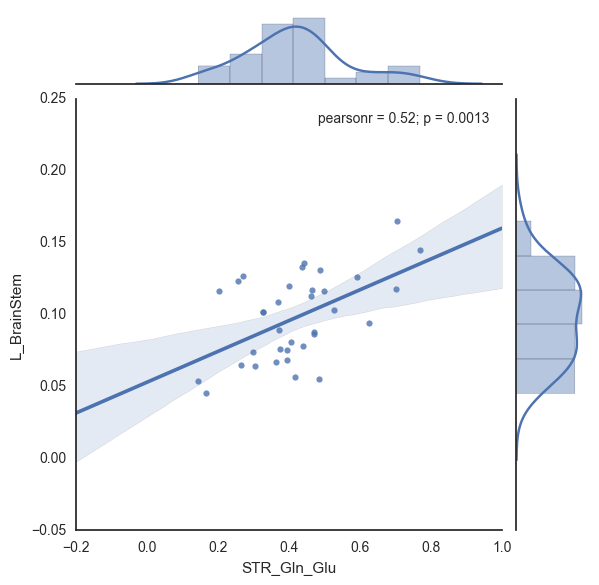

In [6]:
df = DF_ALL.drop(['KDDP'],axis=0)
x = 'STR_Gln_Glu'
y = 'L_BrainStem'
plot_joint(df,x,y, drop = [])

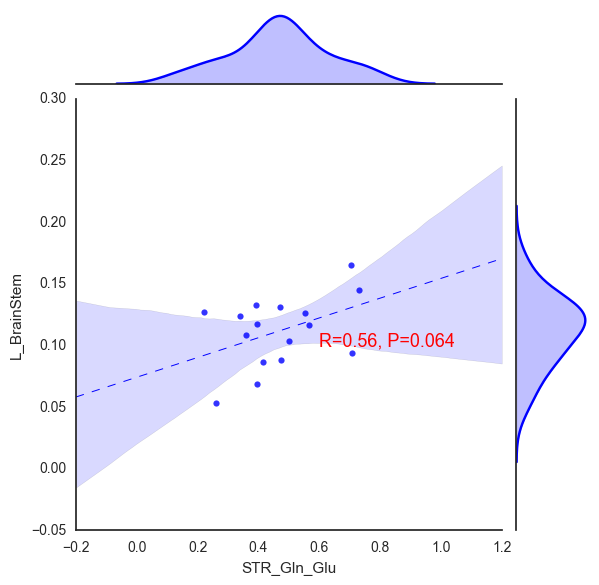

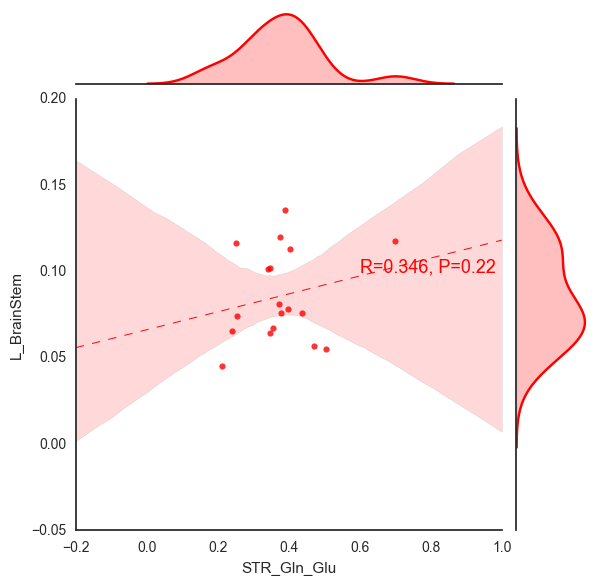

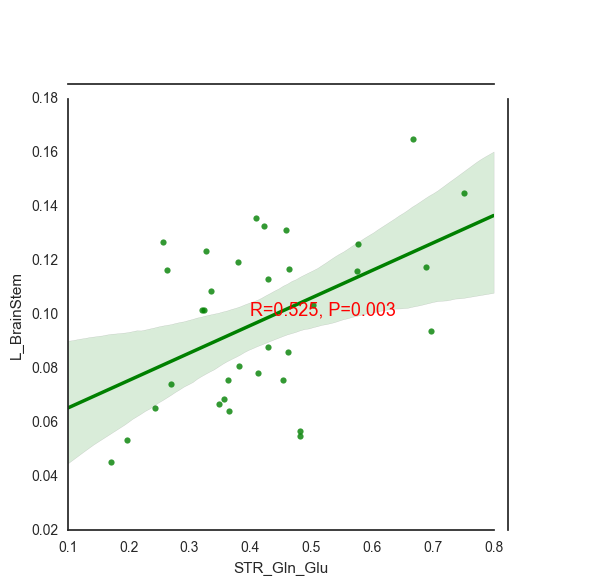

In [7]:
drp = ['SA5U', 'KDDP']
df = DF_ALL.drop(drp,axis=0)
x = 'STR_Gln_Glu'
y = 'L_BrainStem'
regressorsx = ['Gender', 'QI1_MAG']
xlim  = None#(0, 1)
ylim  = None#(-.05,.1750)
dpi = 500 
plot_partial_correlation(controls_a, x, y, regressors = regressorsx, color = 'b', ci = 95,
                         labels = False, annotate = (0.6,0.1), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1, dpi = dpi, xlim=xlim,ylim=ylim, 
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_age_gender_controls.png'
                        )
plot_partial_correlation(patients_a.drop(drp,axis=0), x, y, regressors = regressorsx, color = 'r', ci = 95,
                         labels = False,annotate = (0.6,0.1), lstyle='--', lw=0.7,
                         fit_reg=1, scatter=1, plot_marg = 1,dpi = dpi, xlim=xlim,ylim=ylim,
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_age_gender_patients.png'
                        )
plot_partial_correlation(df, x, y, regressors = regressorsx, color = 'g', 
                         labels = False, annotate =(0.4,0.1), 
                         fit_reg=True, scatter=1, plot_marg = 0, dpi = dpi, xlim=xlim,ylim=ylim,
                       #  fig_name = 'GLUIRON_LSTN_STRGlnGLu_reg_agegender_ALL.png'
                        )




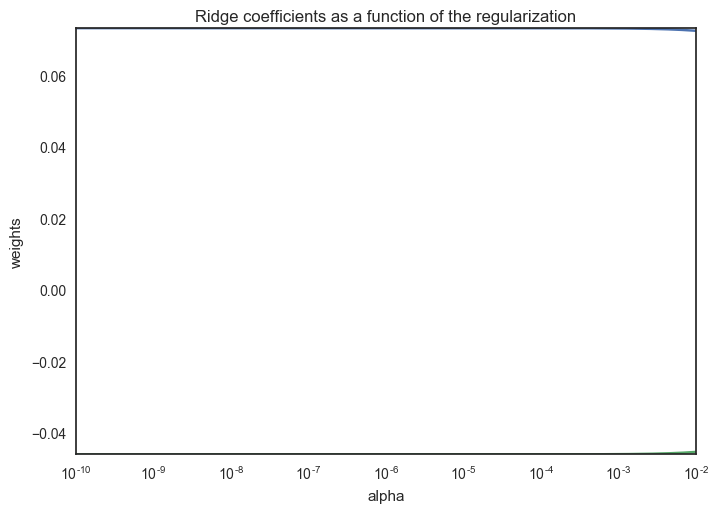

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# X is the 10x10 Hilbert matrix
df = pd.concat([DF_ALL.L_BrainStem,DF_ALL.STR_Gln_Glu, DF_ALL.Age], axis=1).dropna()
X = np.array([df.STR_Gln_Glu.T.values , df.Age.T.values / 10]).reshape(36,2)
y = np.array(df.L_BrainStem)


n_alphas = 1000
alphas = np.logspace(-10, -2, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)
    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
#plt.ylim(0.00022069555829533707,0.00022069555881830393)
plt.show()

In [35]:
mod = smf.ols('L_BrainStem ~ STR_Gln_Glu + Age ', data=df).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            L_BrainStem   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     10.42
Date:                Wed, 26 Oct 2016   Prob (F-statistic):           0.000311
Time:                        18:47:06   Log-Likelihood:                 85.240
No. Observations:                  36   AIC:                            -164.5
Df Residuals:                      33   BIC:                            -159.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0328      0.015      2.216      0.034         0.003     0.063
STR_Gln_Glu     0.0711      0.027      2.611      0.013         0.016     0.126
Age             0.0010      0.000      2.617      0.013         0.000     0.002
==============================================================================
Omnibus:                        0.292   Durbin-Watson:                   2.362
Prob(Omnibus):                  0.864   Jarque-Bera (JB):                0.050
Skew:                          -0.091   Prob(JB):                        0.975
Kurtosis:                       2.998   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
df = pd.concat([DF_ALL.L_BrainStem, DF_ALL.CLN_Ferritin, DF_ALL.Age], axis=1).dropna()
corr = np.corrcoef(df, rowvar=0) 
w, v = np.linalg.eig(corr)
w

array([ 1.95540741,  0.68103823,  0.36355437])

In [32]:
X

array([[-0.07855639, -1.70126052],
       [ 0.41000874,  0.40367185],
       [-0.97619936,  1.41650044],
       [ 0.51769809,  0.5879888 ],
       [-0.89293785,  0.19055226],
       [ 2.34158674, -0.2522069 ],
       [ 1.93182651,  0.37044662],
       [ 0.78118325,  1.20389071],
       [-0.28236821,  0.21556634],
       [-0.52204422, -1.56586989],
       [-0.08059549, -0.21803593],
       [-0.92347358,  0.35874115],
       [-0.6995373 , -1.32846106],
       [ 0.07344041, -0.51532628],
       [-0.23338599, -0.65762795],
       [ 0.22253362, -0.0062721 ],
       [ 1.90270372,  0.50752264],
       [-0.04021512, -2.46148775],
       [-0.25236317, -1.5507751 ],
       [ 1.05973026,  0.66982374],
       [-0.92337429,  1.52353752],
       [ 0.34447306,  1.19173867],
       [-0.6704426 ,  0.21767644],
       [ 1.46279778, -0.4803593 ],
       [ 1.98044473,  0.66743277],
       [ 1.17562692,  1.24955628],
       [-0.21530411,  0.4104568 ],
       [-0.39950479, -1.51005969],
       [-0.19196997,

In [33]:
y

array([-0.98492008, -1.50969743, -0.38013215, -0.32584007,  0.9046882 ,
       -0.11765138,  1.17389217,  0.65635607,  1.02157273,  1.23046368,
        1.65439315,  0.395936  ,  2.33855849,  0.68408923,  0.21414504,
        0.993782  , -1.04661457, -0.65817757,  0.14799528, -1.79744773,
       -0.74590141, -0.74399036, -1.10695061,  0.54704664, -0.79318248,
        0.66404629, -1.40013473,  0.15886291, -0.27638317, -1.13874763,
        1.32577413, -0.56735692,  0.70355655, -1.46063194,  0.77355143,
       -0.53494975])